In [189]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/90+_DaysPastDue/90+DPD_files")

train = pd.read_csv("FITB_train.csv", na_values=["", "NA"])

test = pd.read_csv("FITB_test.csv", na_values=["", "NA"])

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# disabled code to remove the upper and lower quartiles of feature 3

In [190]:
# Calculate 1st and 99th percentiles for feature_3
lower_bound = train['feature_3'].quantile(0.01)
upper_bound = train['feature_3'].quantile(0.99)

# Remove outliers from train set
train = train[(train['feature_3'] >= lower_bound) & (train['feature_3'] <= upper_bound)]

# Apply same bounds to test set for consistency
test = test[(test['feature_3'] >= lower_bound) & (test['feature_3'] <= upper_bound)]


fill in the NA's of feature 3

In [191]:
na_indices_train = train[train['feature_3'].isna()].index
median_value = train['feature_3'].median()
train['feature_3'].fillna(median_value, inplace=True)
train.rename(columns={'feature_3': 'feature_3_impute'}, inplace=True)

na_indices_test = test[test['feature_3'].isna()].index
median_value = test['feature_3'].median()
test['feature_3'].fillna(median_value, inplace=True)
test.rename(columns={'feature_3': 'feature_3_impute'}, inplace=True)

fill in the NA's of feature 2

In [192]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])  
    df['feature_2'] = df['feature_2'].fillna(method='bfill') 
    df['feature_2'] = df['feature_2'].fillna(method='ffill') 
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

train.rename(columns={'feature_2': 'feature_2_impute'}, inplace=True)
test.rename(columns={'feature_2': 'feature_2_impute'}, inplace=True)

train = train.dropna(subset=['feature_2_impute'])
test = test.dropna(subset=['feature_2_impute'])

encode outocomes to 1 and 0 

In [193]:
train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

original_train = train.copy()
original_test = test.copy()

Now that all the NA's are gone, 

Preliminary diagnostics for suitability of Logistic Regression. 

In [194]:

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Standardize features
scaler = StandardScaler()
features = ['feature_1', 'feature_2_impute', 'feature_3_impute', 'feature_4']
X_scaled = scaler.fit_transform(train[features])
X_scaled = pd.DataFrame(X_scaled, columns=[f'{col}_standard' for col in features])

# Add y column to scaled dataframe
X_scaled['y'] = train['y']



# Fit logistic regression model
y = train['y']
model = LogisticRegression()
model.fit(X_scaled.drop('y', axis=1), y)

# Store feature means
feature_means = X_scaled.drop('y', axis=1).mean()


train = X_scaled

In [195]:
# Standardize test features using same scaler
X_test_scaled = scaler.transform(test[features])
test_scaled_features = pd.DataFrame(X_test_scaled, columns=[f'{col}_standard' for col in features])

# Create new test dataframe with scaled features and original remaining columns
test = pd.concat([test_scaled_features, test.drop(columns=features)], axis=1)

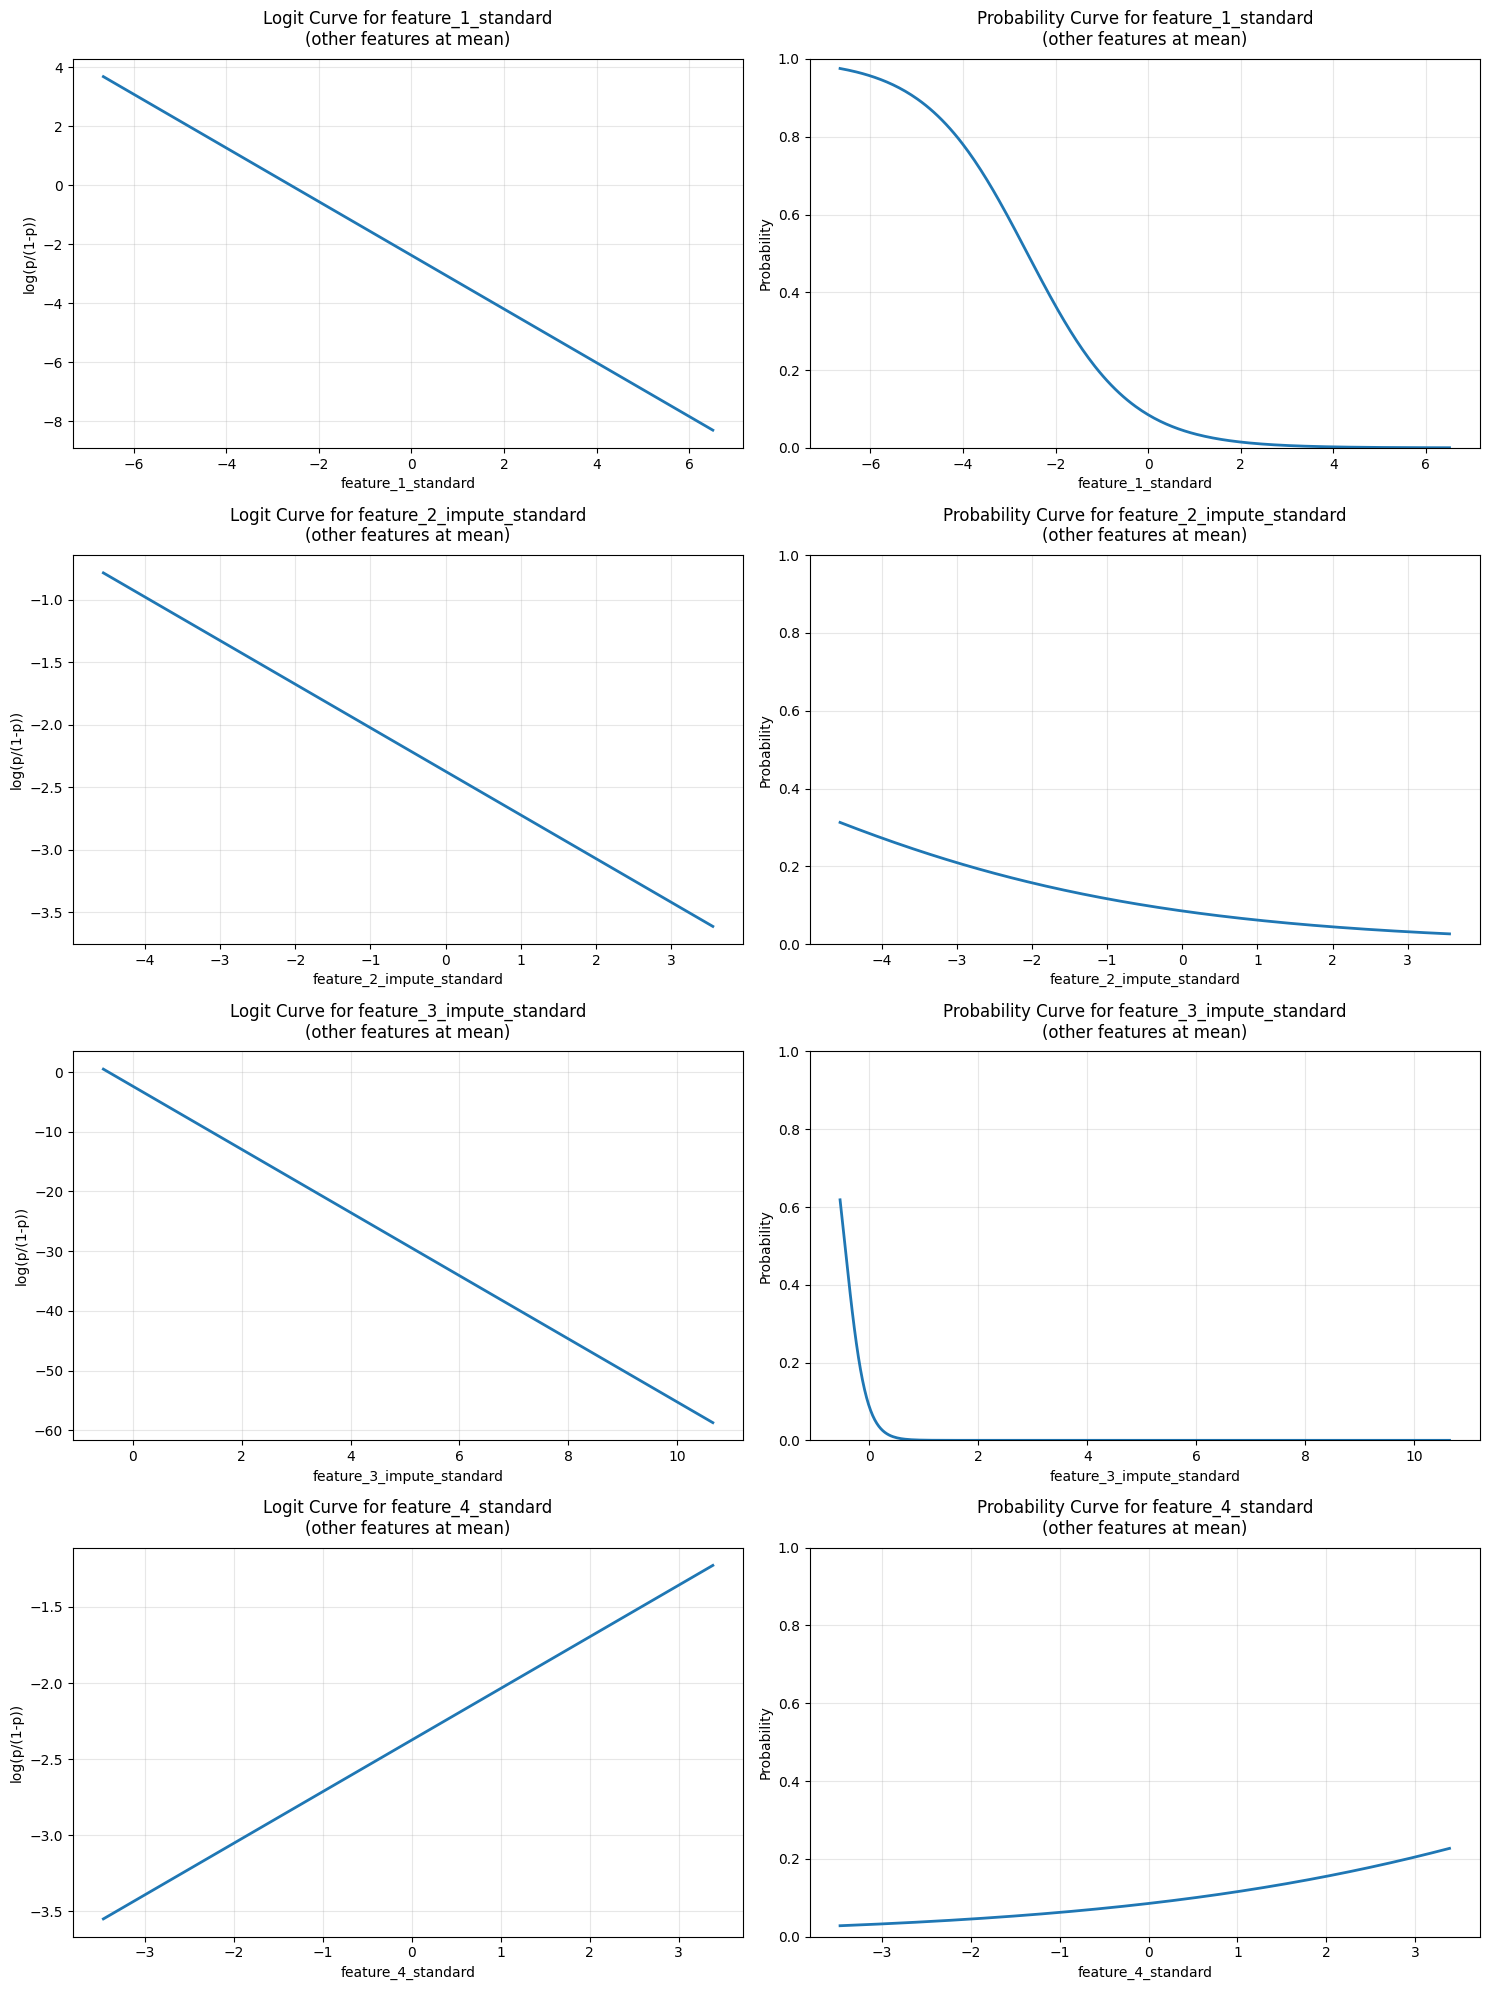

In [196]:
# Create figure with subplots for all features
fig, axes = plt.subplots(4, 2, figsize=(15, 20))

features_standard = [f'{col}_standard' for col in features]

# Calculate predictions for each feature
for idx, feature in enumerate(features_standard):
    # Create range of current feature values for plotting
    feature_range = np.linspace(X_scaled[feature].min(), X_scaled[feature].max(), 300)
    
    # Create prediction matrix where other features are held at their means
    X_pred = np.tile(feature_means, (300, 1))  # Create 300 rows of mean values
    X_pred = pd.DataFrame(X_pred, columns=features_standard)  # Convert to DataFrame
    X_pred[feature] = feature_range  # Vary only the current feature
    
    # Get predictions
    y_pred_proba = model.predict_proba(X_pred)[:, 1]
    y_pred_logit = np.log(y_pred_proba / (1 - y_pred_proba))

    # Plot logit curve
    axes[idx, 0].plot(feature_range, y_pred_logit, linewidth=2)
    axes[idx, 0].set_title(f'Logit Curve for {feature}\n(other features at mean)', fontsize=12, pad=10)
    axes[idx, 0].set_xlabel(feature, fontsize=10)
    axes[idx, 0].set_ylabel('log(p/(1-p))', fontsize=10)
    axes[idx, 0].grid(True, alpha=0.3)

    # Plot probability curve
    axes[idx, 1].plot(feature_range, y_pred_proba, linewidth=2)
    axes[idx, 1].set_title(f'Probability Curve for {feature}\n(other features at mean)', fontsize=12, pad=10)
    axes[idx, 1].set_xlabel(feature, fontsize=10)
    axes[idx, 1].set_ylabel('Probability', fontsize=10)
    axes[idx, 1].grid(True, alpha=0.3)
    axes[idx, 1].set_ylim(0, 1)  # Set probability range from 0 to 1

plt.tight_layout()
plt.show()


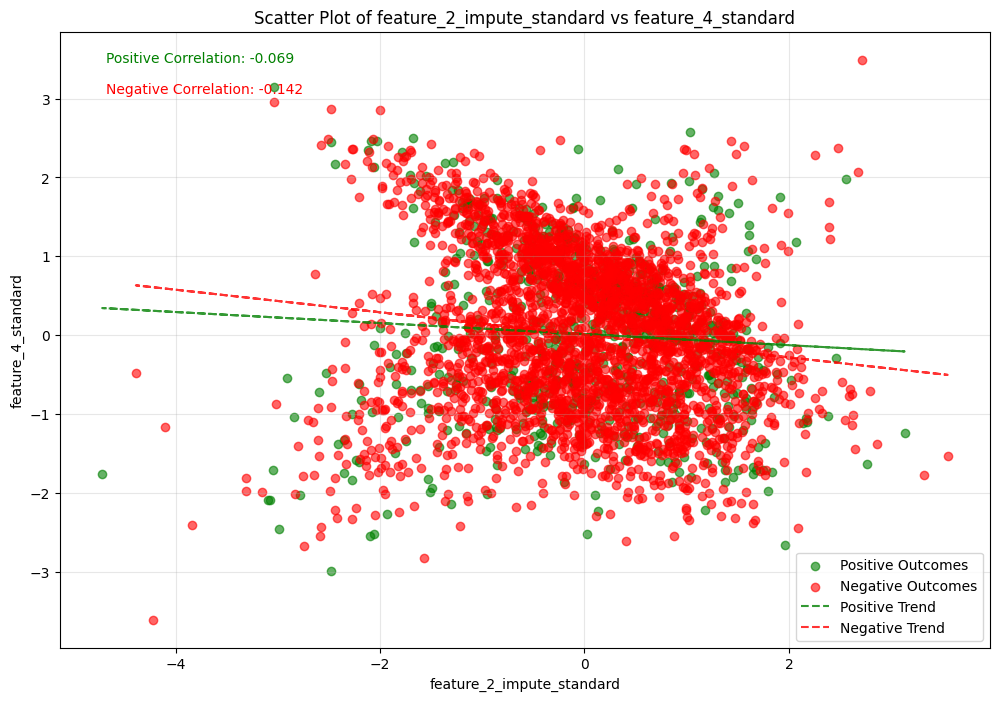

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def plot_scatter_with_separate_correlations(df, continuous_vars, target_var='y', positive_value=1, negative_value=0):
    """
    Generate scatter plots with separate correlation coefficients for positive and negative outcomes.
    Points are slightly offset when they overlap to show intersection.
    Adds trend lines for positive and negative outcomes.
    
    Parameters:
    - df: DataFrame containing the data
    - continuous_vars: List of continuous variable column names
    - target_var: Name of the binary target column (default='y')
    - positive_value: Value representing positive outcomes (default=1)
    - negative_value: Value representing negative outcomes (default=0)
    """
    # Create figure with subplots
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Split data into positive and negative outcomes
    positive_data = df[df[target_var] == positive_value]
    negative_data = df[df[target_var] == negative_value]
    
    # Calculate correlations for positive and negative outcomes
    pos_corr = positive_data[continuous_vars[0]].corr(positive_data[continuous_vars[1]])
    neg_corr = negative_data[continuous_vars[0]].corr(negative_data[continuous_vars[1]])
    
    # Add small random offset to points that overlap
    offset = 0.2
    pos_x = positive_data[continuous_vars[0]] + np.random.uniform(-offset, offset, len(positive_data))
    pos_y = positive_data[continuous_vars[1]] + np.random.uniform(-offset, offset, len(positive_data))
    neg_x = negative_data[continuous_vars[0]] + np.random.uniform(-offset, offset, len(negative_data))
    neg_y = negative_data[continuous_vars[1]] + np.random.uniform(-offset, offset, len(negative_data))
    
    # Create scatter plot with offset points
    plt.scatter(pos_x, pos_y, color='green', label='Positive Outcomes', alpha=0.6)
    plt.scatter(neg_x, neg_y, color='red', label='Negative Outcomes', alpha=0.6)
    
    # Add trend lines
    # For positive outcomes
    pos_z = np.polyfit(pos_x, pos_y, 1)
    pos_p = np.poly1d(pos_z)
    plt.plot(pos_x, pos_p(pos_x), "g--", alpha=0.8, label='Positive Trend')
    
    # For negative outcomes
    neg_z = np.polyfit(neg_x, neg_y, 1)
    neg_p = np.poly1d(neg_z)
    plt.plot(neg_x, neg_p(neg_x), "r--", alpha=0.8, label='Negative Trend')
    
    # Add correlation annotations
    plt.text(0.05, 0.95, f'Positive Correlation: {pos_corr:.3f}',
             transform=ax.transAxes, color='green', fontsize=10)
    plt.text(0.05, 0.90, f'Negative Correlation: {neg_corr:.3f}',
             transform=ax.transAxes, color='red', fontsize=10)
    
    plt.title(f'Scatter Plot of {continuous_vars[0]} vs {continuous_vars[1]}')
    plt.xlabel(continuous_vars[0])
    plt.ylabel(continuous_vars[1])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Continuous variables and target variable
continuous_vars = ['feature_2_impute_standard', 'feature_4_standard']
target_var = 'y'

# Call the function with the DataFrame
plot_scatter_with_separate_correlations(X_scaled, continuous_vars, target_var, positive_value=1, negative_value=0)

What this means is that throughout the data there is a strong pattern of posative responses in observations where feature 2 and feature 4 are increasing. This is indicative of high predictive power.

This does not mean that feature 2 and 4 are responsible for the observations being posative, what this mean that along the trend line of posative outcomes between feature 2 and 4, the other variabels are at a position along their span which greatly adds to the predicted probability of posative outcome. 

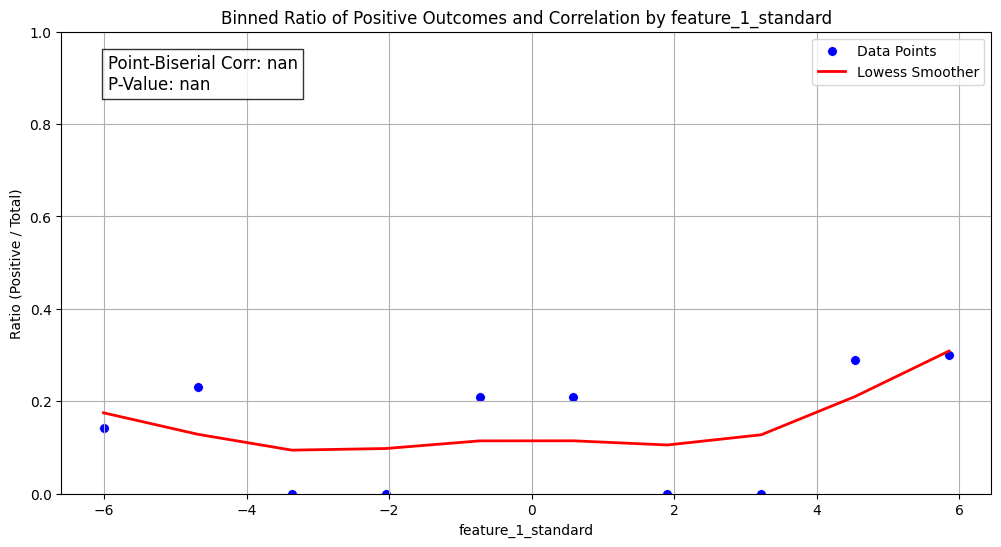

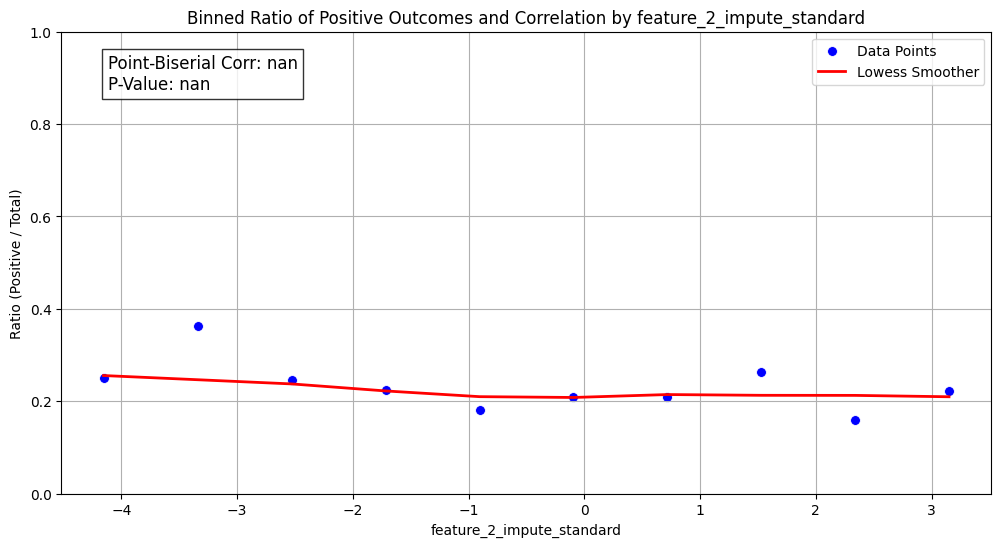

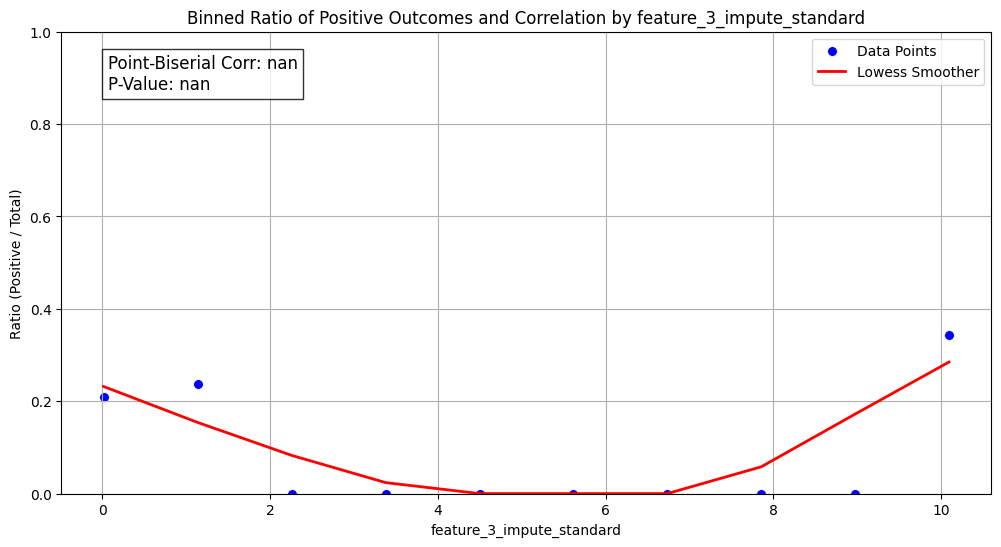

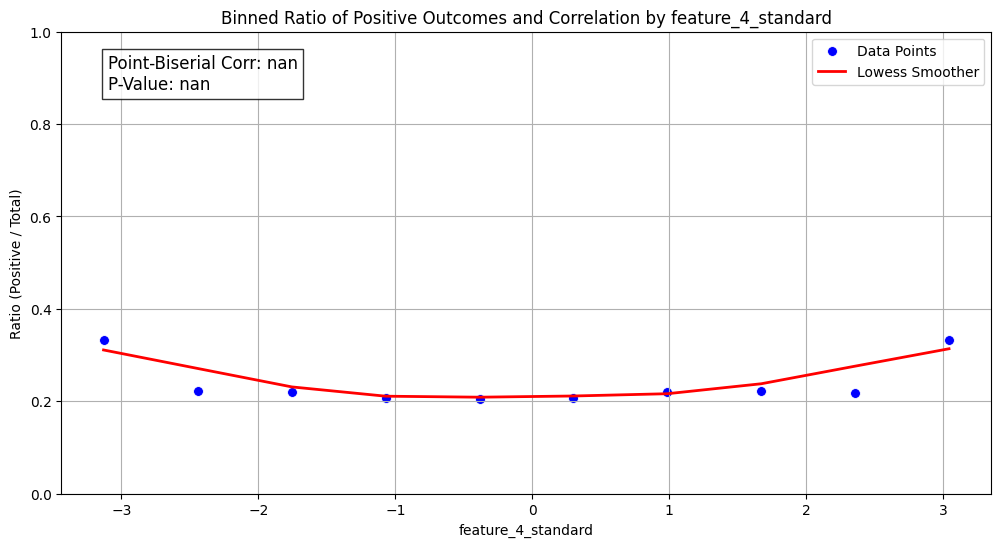

In [198]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr

def plot_ratio_positive_negative_with_corr_binned(df, continuous_var, categorical_var='y', positive_value=1, negative_value=0, bins=10):
    """
    Plot the ratio of positive to total outcomes for a binned continuous variable with a scatter plot
    and display the correlation coefficient.
    
    Parameters:
    - df: DataFrame containing the data.
    - continuous_var: Name of the continuous predictor column.
    - categorical_var: Name of the binary target column.
    - positive_value: Value representing positive outcomes (default=1).
    - negative_value: Value representing negative outcomes (default=0).
    - bins: Number of bins to divide the continuous variable (default=10).
    """
    # Bin the continuous variable
    df['binned'] = pd.cut(df[continuous_var], bins=bins, include_lowest=True)
    
    # Group by binned variable and category to get counts
    grouped = df.groupby(['binned', categorical_var]).size().reset_index(name='count')
    
    # Pivot so we have positive and negative counts
    pivot = grouped.pivot(index='binned', columns=categorical_var, values='count').fillna(0)
    
    # Extract positive and total counts
    positive_counts = pivot[positive_value] if positive_value in pivot.columns else 0
    total_counts = positive_counts + pivot[negative_value] if negative_value in pivot.columns else positive_counts

    # To avoid division by zero, add a small epsilon
    epsilon = 1e-9
    ratio = positive_counts / (total_counts + epsilon)

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'binned': ratio.index.astype(str),  # Convert bin intervals to strings for plotting
        'ratio_positive_negative': ratio.values,
        continuous_var: [interval.mid for interval in ratio.index]  # Extract midpoints for x-axis
    })
    
    # Calculate Point-Biserial Correlation (on original data)
    correlation, p_value = pointbiserialr(df[continuous_var], df[categorical_var])
    
    # Plot the points and smoother
    plt.figure(figsize=(12, 6))
    
    # Scatter plot of ratio points
    sns.scatterplot(x=continuous_var, y='ratio_positive_negative', data=plot_df, color='blue', s=50, label='Data Points')

    # Add a smooth trend line (lowess)
    sns.regplot(x=continuous_var, y='ratio_positive_negative', data=plot_df, 
                scatter=False, lowess=True, color='red', line_kws={'lw': 2}, label='Lowess Smoother')

    # Add the correlation coefficient as text on the plot
    plt.text(0.05, 0.95, f'Point-Biserial Corr: {correlation:.4f}\nP-Value: {p_value:.4e}', 
             transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8))
    
    # Final plot settings
    plt.title(f'Binned Ratio of Positive Outcomes and Correlation by {continuous_var}')
    plt.xlabel(continuous_var)
    plt.ylabel('Ratio (Positive / Total)')
    plt.ylim(0, 1)  # Ratio ranges between 0 and 1
    plt.legend()
    plt.grid()
    plt.show()

# Plot for each standardized feature
plot_ratio_positive_negative_with_corr_binned(X_scaled, 'feature_1_standard', 'y', positive_value=1, negative_value=0, bins=10)
plot_ratio_positive_negative_with_corr_binned(X_scaled, 'feature_2_impute_standard', 'y', positive_value=1, negative_value=0, bins=10)
plot_ratio_positive_negative_with_corr_binned(X_scaled, 'feature_3_impute_standard', 'y', positive_value=1, negative_value=0, bins=10)
plot_ratio_positive_negative_with_corr_binned(X_scaled, 'feature_4_standard', 'y', positive_value=1, negative_value=0, bins=10)

we want to maximize recall

Training Accuracy: 0.7998390126106788
Testing Accuracy: 0.8075396825396826

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.84      0.93      0.89       804
           1       0.54      0.31      0.40       204

    accuracy                           0.81      1008
   macro avg       0.69      0.62      0.64      1008
weighted avg       0.78      0.81      0.79      1008



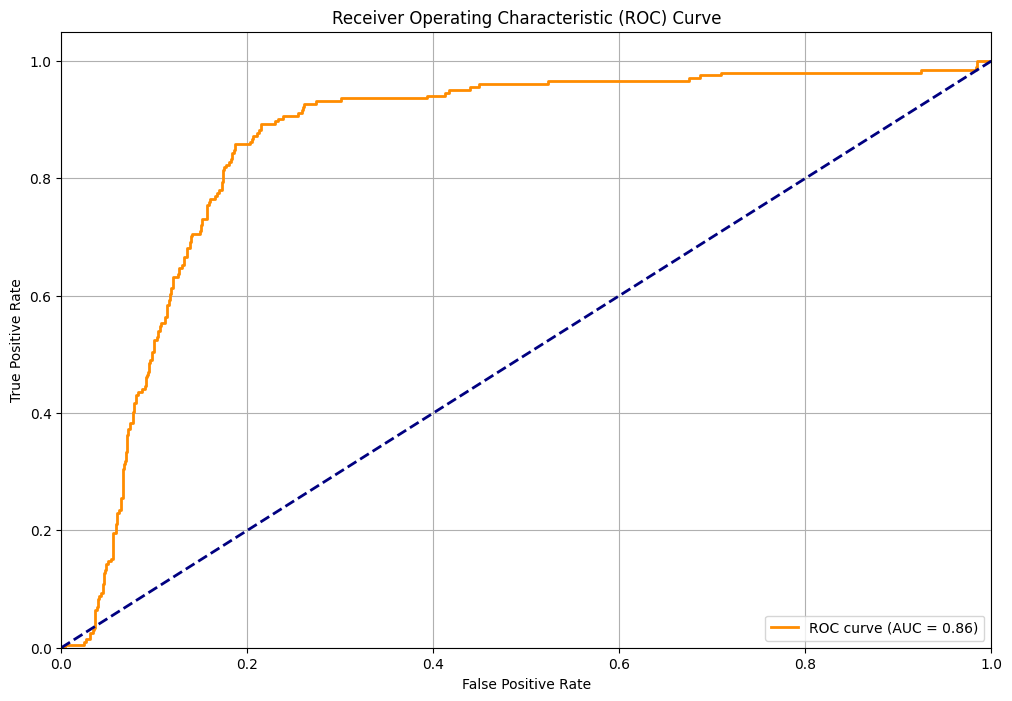

In [199]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

X_train = original_train[['feature_1', 'feature_2_impute', 'feature_3_impute', 'feature_4']]
y_train = original_train['y']

X_test = original_test[['feature_1', 'feature_2_impute', 'feature_3_impute', 'feature_4']]
y_test = original_test['y']

lr_model = LogisticRegression(fit_intercept=True)
lr_model.fit(X_train, y_train)

train_pred = lr_model.predict(X_train)
test_pred = lr_model.predict(X_test)
test_pred_proba = lr_model.predict_proba(X_test)[:,1]

print("Training Accuracy:", accuracy_score(y_train, train_pred))
print("Testing Accuracy:", accuracy_score(y_test, test_pred))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, test_pred))

fpr, tpr, thresholds = roc_curve(y_test, test_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

Training Accuracy: 1.0
Testing Accuracy: 0.9623015873015873

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       804
           1       0.96      0.85      0.90       204

    accuracy                           0.96      1008
   macro avg       0.96      0.92      0.94      1008
weighted avg       0.96      0.96      0.96      1008



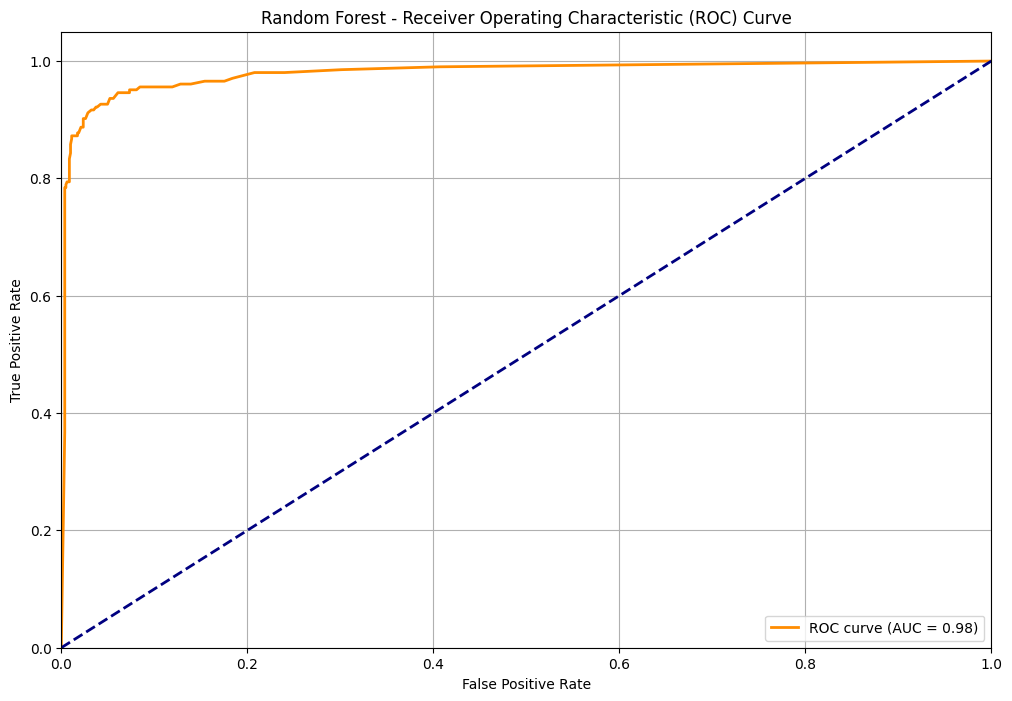

In [200]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

rf_train_pred = rf_model.predict(X_train)
rf_test_pred = rf_model.predict(X_test)
rf_test_pred_proba = rf_model.predict_proba(X_test)[:,1]

print("Training Accuracy:", accuracy_score(y_train, rf_train_pred))
print("Testing Accuracy:", accuracy_score(y_test, rf_test_pred))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, rf_test_pred))

rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_test_pred_proba)
rf_roc_auc = auc(rf_fpr, rf_tpr)

plt.figure(figsize=(12, 8))
plt.plot(rf_fpr, rf_tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
